Importing relevant libraries:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

Creating .gitignore

In [185]:
%%bash
cat > .gitignore
.*
.gitignore

Converting /content into git repository

In [186]:
%%bash
git init

Initialized empty Git repository in /content/.git/


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>


Creating GitHub file structure:

In [171]:
%%bash
rm -r sample_data

In [172]:
%%bash
cat > README.md
This is repository for the figures and analyses created towards the completion of Assignment 8 of CXPT 501 Biomedical Data Science.
The following directories contain the original data, publication ready figures, a probability matrix and code.

In [174]:
%%bash
mkdir startingdata
mkdir figures
mkdir statistics
mkdir code

Defining filepaths for data and output:

In [182]:
csvfilepath = 'https://drive.google.com/uc?export=download&id=1M0ZFQ09JPZGPm0cVJ0gXwENSgwf84cd2'
fig1output = '/content/figures/WHFbytreatmentgroup.pdf'
fig2output = '/content/figures/CREATbytreatmentgroupbyagegroup.pdf'
probmatrixoutput = '/content/statistics/probofdyingbytreatment.csv'
startingdataoutput = '/content/startingdata/fulldata.csv'

Loading data:

In [4]:
#setting context to view all rows and columns
pd.set_option('display.max_rows', 10, 'display.max_columns', 10)

In [ ]:
df = pd.read_csv(csvfilepath)
df

Creating lists of data based on data type:

In [6]:
pd.set_option('display.max_rows', None, 'display.max_columns', 10)

In [ ]:
#checking data types
df.dtypes

In [8]:
# continous data
contdata = ['EJF_PER','CHESTX','CREAT','KLEVEL','BMI']

# discrete data
discrtdata = ['AGE','CHFDUR','HEARTRTE','DIABP','SYSBP','WHFDAYS','DIGDAYS','MIDAYS','UANGDAYS','STRKDAYS','SVADAYS','VENADAYS','CREVDAYS','OCVDDAYS','RINFDAYS','OTHDAYS',
              'HOSPDAYS','NHOSP','DWHFDAYS']

# categorical data
catdata = ['TRTMT','RACE','SEX','RALES','ELEVJVP','PEDEMA','RESTDYS','EXERTDYS','ACTLIMIT','S3','PULCONG','NSYM','FUNCTCLS','CHFETIOL','PREVMI','ANGINA','DIABETES','HYPERTEN',
           'DIGUSE','DIURETK','DIURET','KSUPP','ACEINHIB','NITRATES','HYDRAL','VASOD','DIGDOSE','WHF','DIG','MI','UANG','STRK','SVA','VENA','CREV','CREV','OCVD','RINF','OTH',
           'DEATH','REASON','HOSP','DWHF']

Checking for and cleaning missing data:

In [ ]:
# cleaning missing data for continuous variables by dropping all rows with NaNs
df1 = df.dropna(how='any', subset=contdata)
print(df1.isnull().sum())
df1 = df1.reset_index(drop=True)

In [ ]:
# cleaning missing data for discrete variables by dropping all rows with NaNs
df1 = df1.dropna(how='any',subset=discrtdata)
print(df1.isnull().sum())
df1 = df1.reset_index(drop=True)

In [ ]:
# cleaning missing data for categorical data by replacing all NaNs with 'Not given'
df1 = df1.fillna('Not given')
print(df1.isnull().sum())
df1 = df1.reset_index(drop=True)

Creating a new column showing geriatric status based on age:<br>
0 - age less than 65<br>
1 - age greater than or equal too 65

In [183]:
df1.loc[(df['AGE'] >= 65), 'AGEGRP'] = 1
df1.loc[(df['AGE'] < 65), 'AGEGRP'] = 0
#adding 'AGEGRP' to the list of categorical data
catdata.append('AGEGRP')

#saving the dataframe as start data
df1.to_csv(startingdataoutput, index=False)

Defining functions

In [13]:
#Write a function that will remove outliers from the data given columns or list of columns
def removeoutliers(method,data,columnlist):
  '''
  This function removes outliers from a dataset.
  Outliers are defined as values that fall outside of 3 standard deviations of the data spread.

  Args:
  method - 'list' if removing outliers from a list of columns, 'single' if removing outliers from a single column
  data - This is a Pandas DataFrame
  columnlist - this is a list of all the columns from which outliers need to be removed.
  '''
  #condition for removing outliers from a single column
  if method == 'single':
    #creates a column to store deviations from mean
    data['STD_MEAN'] = (data[columnlist] - data[columnlist].mean()) / data[columnlist].std()
    #saves values greater than 3 SDs to variable 'outliers'
    outliers = data[columnlist].loc[(data['STD_MEAN'] < -3) | (data['STD_MEAN'] > 3)]
    #prints the column name and outliers found
    print(columnlist,outliers)
    #drops the outliers from the table
    data = data.drop(outliers.index)
    #resets the index of the table
    data = data.reset_index(drop=True)

  #condition for removing outliers from a list of columns
  elif method == 'list':
    #generates the number of iterations
    for each in range(0,len(columnlist)):
      #the current column which is being edited
      current = columnlist[each]
      #creates a column to store deviations from mean
      data['STD_MEAN'] = (data[current] - data[current].mean()) / data[current].std()
      #saves values greater than 3 SDs to variable 'outliers'
      outliers = data[current].loc[(data['STD_MEAN'] < -3) | (data['STD_MEAN'] > 3)]
      #prints the column name and outliers found
      print(current,outliers)
      #drops the outliers from the table
      data = data.drop(outliers.index)
      #resets the index of the table
      data = data.reset_index(drop=True)

  #removes the column used to store deviations from mean
  data = data.drop(['STD_MEAN'], axis=1)
  #returns the dataframe with outlier values removed
  return data
  #prints the new dataframe
  print(data)

In [168]:
# write a function that will loop through your count matrix and convert each count into a probability and enter it into the matrix for a probability matrix

def probabilitycrosstab(matrix):
  '''This function will convert your count matrix into a probability matrix.

  Args:
  matrix - this is a pandas DataFrame countaining a count matrix created using the pd.crosstab() function on an imported DataFrame. The crosstab must have margins.

  Returns:
  p_matrix - this is a pandas DataFrame containing a probability matrix.
  '''
  p_matrix = matrix.copy() # make a copy of the argument DataFrame on which to transform data
  total = matrix.iloc[len(matrix.index) - 1,len(matrix) - 1] # provide the total number of subjects/values to use as a denominator for all probabilities retrieved

  '''This section will systematically go through every cell from left to right column starting at the top row. Probabilities of each cell will be calculated by the total.
  The probabilities will be added to the matrix'''
  for x in range(0,len(matrix.index)): # provide number of iterations to loop through each row
    for y in range(0,len(matrix)): # provide number of iterations to loop through each column
      prob_each = matrix.iloc[x,y]/total # calculate the probability of each cell using previously defined probability() function
      p_matrix.iloc[x,y] = prob_each # enter the calculated probability into the correct cell in the matrix

  p_matrix.iloc[len(matrix.index) - 1,len(matrix) - 1] = 1.00 # assigns the probability of the total of the matrix which is always 1.00
  return p_matrix # returns the transformed probability matrix

Comparing the number of deaths in the placebo and treatment groups stratified by presence of worsening heart failure.

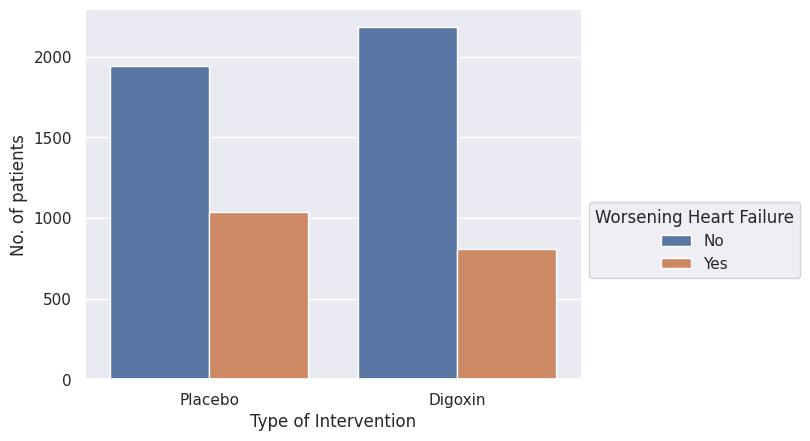

In [176]:
ax = sns.countplot(data=df1, x='TRTMT', hue='WHF')
ax.legend(title='Worsening Heart Failure', labels=['No', 'Yes'], bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'Type of Intervention', ylabel = 'No. of patients')
plt.xticks(ticks=[0,1], labels=['Placebo','Digoxin'])
sns.set(style='whitegrid')
sns.despine()
sns.set_context('paper')
plt.savefig(fig1output, bbox_inches='tight')

Comparing creatinine levels between treatment groups split by age group:

<Axes: ylabel='CREAT'>

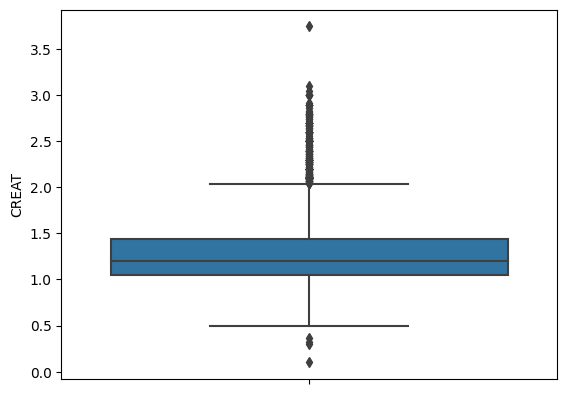

In [88]:
sns.reset_orig()
#checking for data spread and potential outliers
sns.boxplot(y=df1['CREAT'])

In [ ]:
#removing outliers in CREAT using standard deviation method
df2 = removeoutliers('single',df1,'CREAT')

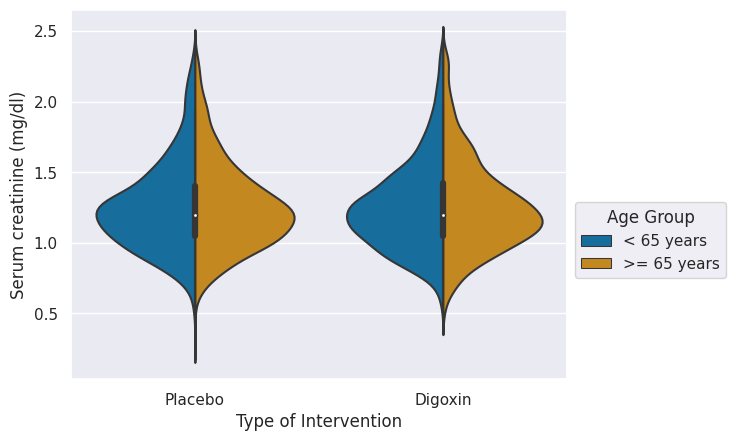

In [177]:
sns.set_context('notebook')
sns.set(style='darkgrid')
df2subset = df2.loc[(df2['AGEGRP']==0)|(df2['AGEGRP']==1)]
ax2 = sns.violinplot(data=df2subset, x='TRTMT',y='CREAT', hue='AGEGRP', split='True', palette='colorblind')
ax2.set(xlabel = 'Type of Intervention', ylabel = 'Serum creatinine (mg/dl)')
plt.xticks(ticks=[0,1], labels=['Placebo','Digoxin'])
handles, labels = ax2.get_legend_handles_labels()
labels = ['< 65 years', '>= 65 years']
ax2.legend(handles, labels, title='Age Group', bbox_to_anchor=(1, 0.5))
plt.savefig(fig2output, bbox_inches='tight')

Creating a probability matrix to calculate probability of death as an outcome based on type of intervention (placebo or digoxin)

In [170]:
#creating a count matrix of treatment group assignment and death as an outcome
outcome = pd.crosstab(df1.TRTMT,df1.DEATH,margins=True)

#creating a probability matrix
prob_outcome = probabilitycrosstab(outcome)

DEATH,0,1,All
TRTMT,,,
0,0.325122,0.173789,0.498911
1,0.326295,0.174795,0.501089
All,0.651416,0.348584,1.000000


In [178]:
#saving matrix to .csv
prob_outcome.to_csv(probmatrixoutput, index=False)

Completing GitHub repo:

In [179]:
%%bash
cd code
cat > README.md
This folder contains the colab notebook analysis as an .ipynb file

In [180]:
%%bash
cd figures
cat > README.md
This folder contains two figures:
CREATbytreatmentgroupbyagegroup - this figure compares the creatinine levels in each treatment group (placebo and digoxin) categorized by age group
WHFbytreatmentgroup - this figure compares the number of patients who did or did not experience worsening heart failure by age group

In [181]:
%%bash
cd statistics
cat > README.md
This folder contains a probability matrix as a .csv file
The probability matrix represents the joint and marginal probabilities of death or no death by treatment group

In [184]:
%%bash
cd startingdata
cat > README.md
This folder contains the initial dataframe used for all analysis and figure generation

Setting Identity

In [187]:
%%bash
git config --global user.email "divgi@usc.edu"
git config --global user.name "KDivgi"

In [ ]:
#adding files
%%bash
